# Utility for reading back Zarr arrays written by `redsun-mimir` acquisitions.

## Store layout
```
    ~/redsun-storage/<session>/<YYYY_MM_DD>_<base>_<counter>.zarr
        └── <device_name>   (array key, e.g. "mmcore", "mmcore_median")
```

## Usage (Jupyter)

```python
stores = list_stores()          # list all stores in the default directory
store  = RedsunStore(stores[-1])  # open the most recent one
print(store)                    # summary of arrays and shapes
arr    = store["mmcore"]        # zarr.Array, shape (T, Y, X)
frame  = store.frame("mmcore", t=0)   # single frame as numpy array
all_frames = store.frames("mmcore")   # all frames as numpy array
```

In [4]:
from pathlib import Path
from collections.abc import Iterator

import numpy as np
import numpy.typing as npt
import zarr
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------------
# Defaults
# ---------------------------------------------------------------------------

DEFAULT_SESSION: str = "redsun-mimir"


# ---------------------------------------------------------------------------
# Store discovery
# ---------------------------------------------------------------------------

def list_stores(
    base_dir: Path | str | None = None,
    *,
    session: str = DEFAULT_SESSION,
    pattern: str = "*.zarr",
) -> list[Path]:
    """Return all Zarr store paths in *base_dir*, sorted oldest-first.

    Parameters
    ----------
    base_dir :
        Root directory to search. Defaults to ``~/redsun-storage/<session>``.
    session :
        Session name used to build the default *base_dir*.
        Ignored when *base_dir* is provided explicitly.
    pattern :
        Glob pattern for store directories. Defaults to ``"*.zarr"``.

    Returns
    -------
    list[Path]
        Sorted list of matching store paths. Empty if none found.
    """
    root: Path = Path(base_dir) if base_dir is not None else Path.home() / "redsun-storage" / session
    if not root.exists():
        return []
    return sorted(root.glob(pattern))


def latest_store(
    base_dir: Path | str | None = None,
    *,
    session: str = DEFAULT_SESSION,
) -> Path | None:
    """Return the most recently created Zarr store, or ``None`` if none exist.

    Parameters
    ----------
    base_dir :
        Root directory to search.
    session :
        Session name used to build the default *base_dir*.

    Returns
    -------
    Path | None
    """
    stores = list_stores(base_dir, session=session)
    return stores[-1] if stores else None


# ---------------------------------------------------------------------------
# Store wrapper
# ---------------------------------------------------------------------------

class RedsunStore:
    """Read-only wrapper around a single redsun-mimir Zarr store.

    acquire-zarr writes each device as a named array inside a Zarr group
    at the store root. With zarr v3, ``zarr.open_group`` handles this correctly.

    Parameters
    ----------
    path :
        Path to the ``.zarr`` store directory.

    Raises
    ------
    FileNotFoundError
        If *path* does not exist.
    """

    def __init__(self, path: Path | str) -> None:
        self._path: Path = Path(path)
        if not self._path.exists():
            raise FileNotFoundError(f"Store not found: {self._path}")
        self._store: zarr.Group = zarr.open_group(str(self._path), mode="r")

    # ------------------------------------------------------------------
    # Dunder helpers
    # ------------------------------------------------------------------

    def __repr__(self) -> str:
        lines: list[str] = [f"RedsunStore({self._path.name})"]
        for key in self.keys():
            arr: zarr.Array = self._store[key]
            lines.append(f"  {key!r:30s}  shape={arr.shape}  dtype={arr.dtype}")
        return "\n".join(lines)

    def __str__(self) -> str:
        return self.__repr__()

    def __getitem__(self, key: str) -> zarr.Array:
        """Return the raw :class:`zarr.Array` for *key* (device name).

        Parameters
        ----------
        key :
            Device name, e.g. ``"mmcore"`` or ``"mmcore_median"``.

        Raises
        ------
        KeyError
            If *key* is not present in the store.
        """
        return self._store[key]

    def __contains__(self, key: str) -> bool:
        return key in self._store

    def __iter__(self) -> Iterator[str]:
        return iter(self.keys())

    # ------------------------------------------------------------------
    # Accessors
    # ------------------------------------------------------------------

    @property
    def path(self) -> Path:
        """Filesystem path to the ``.zarr`` store directory."""
        return self._path

    def keys(self) -> list[str]:
        """Return the list of array keys (device names) in the store."""
        return list(self._store.keys())

    def frame(self, key: str, t: int = 0) -> npt.NDArray[np.generic]:
        """Return a single frame at time index *t* for device *key*.

        Parameters
        ----------
        key :
            Device name.
        t :
            Frame index along the time axis. Defaults to ``0``.

        Returns
        -------
        numpy.ndarray
            2-D array of shape ``(Y, X)``.

        Raises
        ------
        KeyError
            If *key* is not in the store.
        IndexError
            If *t* is out of range.
        """
        arr: zarr.Array = self._store[key]
        n_frames: int = arr.shape[0]
        if t < 0 or t >= n_frames:
            raise IndexError(f"Frame index {t} out of range [0, {n_frames})")
        return np.asarray(arr[t])

    def frames(
        self,
        key: str,
        start: int = 0,
        stop: int | None = None,
    ) -> npt.NDArray[np.generic]:
        """Return a stack of frames for device *key*.

        Parameters
        ----------
        key :
            Device name.
        start :
            First frame index (inclusive). Defaults to ``0``.
        stop :
            Last frame index (exclusive). Defaults to all frames.

        Returns
        -------
        numpy.ndarray
            3-D array of shape ``(T, Y, X)``.
        """
        arr: zarr.Array = self._store[key]
        return np.asarray(arr[start:stop])

    def info(self, key: str) -> dict[str, object]:
        """Return metadata for the array at *key*.

        Parameters
        ----------
        key :
            Device name.

        Returns
        -------
        dict
            Dictionary with ``path``, ``shape``, ``dtype``,
            ``chunks``, and ``n_frames`` entries.
        """
        arr: zarr.Array = self._store[key]
        return {
            "path": str(self._path / key),
            "shape": arr.shape,
            "dtype": arr.dtype,
            "chunks": arr.chunks,
            "n_frames": arr.shape[0],
        }

In [5]:
stores = list_stores()
print(f"Available stores: {stores}")
store = RedsunStore(stores[-1])
print(store)

Available stores: [WindowsPath('C:/Users/jacop/redsun-storage/redsun-mimir/2026_02_23_00001.zarr')]
RedsunStore(2026_02_23_00001.zarr)
  'mmcore'                        shape=(10, 100, 100)  dtype=uint8
  'mmcore_median'                 shape=(1, 100, 100)  dtype=float64


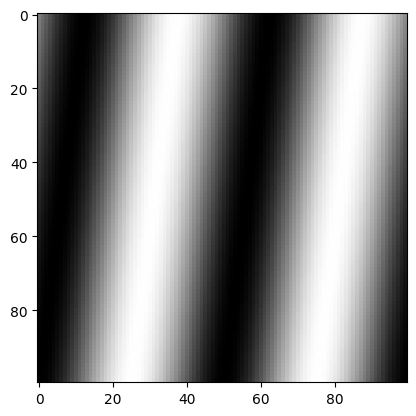

In [ ]:
frame  = store.frame("mmcore", t=0)      # one frame  → (100, 100)
stack  = store.frames("mmcore")          # all frames → (10, 100, 100)
median = store.frame("mmcore_median")    # the median → (100, 100)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(frame, cmap="gray")
axes[0].set_title("frame")

axes[1].imshow(median, cmap="gray")
axes[1].set_title("median")

plt.tight_layout()
plt.show()